Author: Darian Hadjiabadi

In this notebook I create images which users will then access to determine real vs fake.

In [1]:
import numpy as np
from scipy import misc
import glob
from gan.network_utils import show_images
from scipy import ndimage

%load_ext autoreload
%autoreload 2


In [2]:

batch_size = 64
img_size = 64
real_testing_dir = 'database-imgs-full/pyramidal/test/a/'
fake_testing_dir_smoothing = 'output-large/pyramidal/label-smoothing/'
fake_testing_dir_nsmoothing = 'output-large/pyramidal/no-label-smoothing/'

def read_imgs(imgs, dir_fn):
    count = 0
    for image_path in glob.glob(dir_fn + '*.png'):
        image = misc.imread(image_path)
        imgs[count, :, :] = image
        count += 1
        
def count_to_str(count):
    if count < 10:
        return '00000' + str(count)
    elif count >= 10 and count < 100:
        return '0000' + str(count)
    elif count >= 100 and count < 1000:
        return '000' + str(count)
    elif count >= 1000 and count < 10000:
        return '00' + str(count)
    elif count >= 10000 and count < 100000:
        return '0' + str(count)
    
def save_imgs(imgs, dir_path):
    import scipy.misc
    imgs = np.reshape(imgs, [imgs.shape[0], -1])
    sqrtimg = int(np.ceil(np.sqrt(imgs.shape[1])))
    imgs = np.reshape(imgs, (imgs.shape[0], sqrtimg, sqrtimg))
    
    for i in range(imgs.shape[0]):
        nstr = count_to_str(i)
        fn_full = 'img-' + nstr + '.png'
        scipy.misc.imsave(dir_path + fn_full, imgs[i,:,:])     

In [3]:
# Read in images from directories

real_imgs = np.zeros((batch_size, img_size, img_size))
read_imgs(real_imgs, real_testing_dir)

fake_imgs_smoothing = np.zeros((batch_size, img_size, img_size))
read_imgs(fake_imgs_smoothing, fake_testing_dir_smoothing)

fake_imgs_nsmoothing = np.zeros((batch_size, img_size, img_size))
read_imgs(fake_imgs_nsmoothing, fake_testing_dir_nsmoothing)

print('images read in')


   

images read in


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


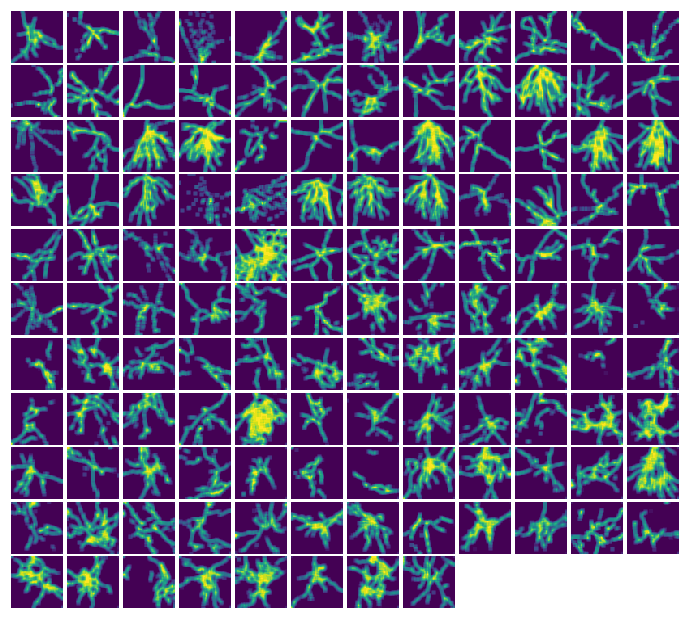

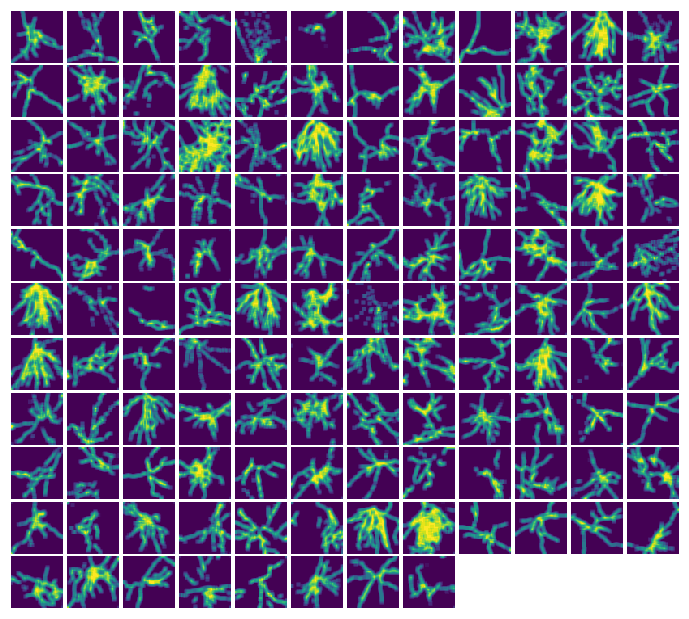

In [4]:
# Generate random numbers in which to shuffle fake and real images

testing_imgs_smoothing = np.zeros((2*batch_size, img_size, img_size))

for i in range(real_imgs.shape[0]):
    smoothed_image = ndimage.uniform_filter(real_imgs[i,:,:], size=5)
    testing_imgs_smoothing[i,:,:] = smoothed_image
for i in range(fake_imgs_smoothing.shape[0]):
    smoothed_image = ndimage.uniform_filter(fake_imgs_smoothing[i,:,:], size=5)
    testing_imgs_smoothing[i+batch_size,:,:] = smoothed_image
 
ordering_list = np.arange(testing_imgs_smoothing.shape[0])
np.random.shuffle(ordering_list)

real_fake_list = []
for i in range(len(ordering_list)):
    if ordering_list[i] < batch_size:
        real_fake_list.append(1)
    else:
        real_fake_list.append(0)

shuffled_images = np.zeros((2*batch_size, img_size, img_size))
for i in range(len(ordering_list)):
    pos = ordering_list[i]
    shuffled_images[i,:,:] = testing_imgs_smoothing[pos,:,:]

rf_f = open('output-large/pyramidal/label-smoothing/testing/real_fake_list.txt','w')
for rf in real_fake_list:
    rf_f.write(str(rf) + '\n')
rf_f.close()

output_dir = 'output-large/pyramidal/label-smoothing/testing/'    
save_imgs(shuffled_images, output_dir)


show_images(testing_imgs_smoothing)
show_images(shuffled_images)



/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


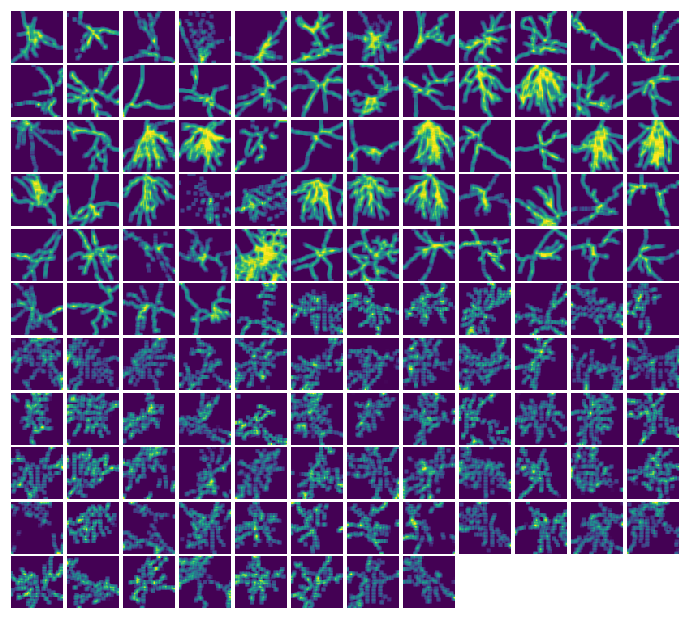

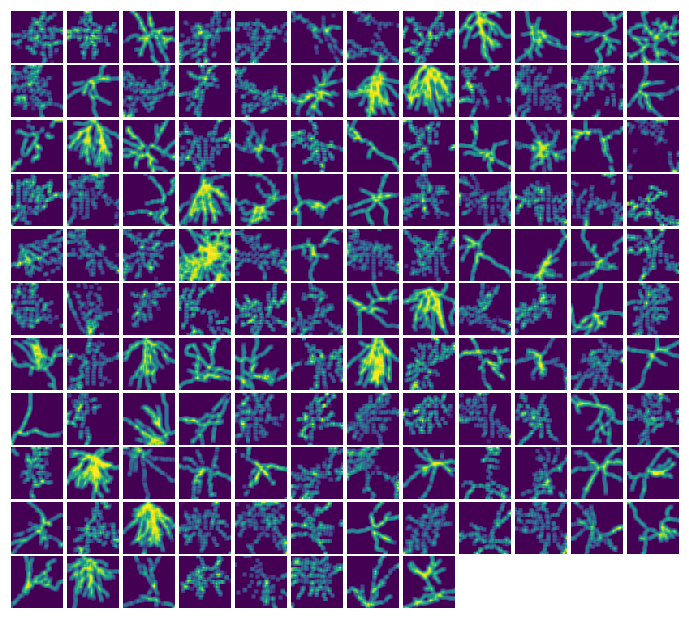

In [5]:
# Generate random numbers in which to shuffle fake and real images

testing_imgs_nsmoothing = np.zeros((2*batch_size, img_size, img_size))
for i in range(real_imgs.shape[0]):
    smoothed_image = ndimage.uniform_filter(real_imgs[i,:,:], size=5)
    testing_imgs_nsmoothing[i,:,:] = smoothed_image
for i in range(fake_imgs_nsmoothing.shape[0]):
    smoothed_image = ndimage.uniform_filter(fake_imgs_nsmoothing[i,:,:], size=5)
    testing_imgs_nsmoothing[i+batch_size,:,:] = smoothed_image
    
ordering_list = np.arange(testing_imgs_nsmoothing.shape[0])
np.random.shuffle(ordering_list)

real_fake_list = []
for i in range(len(ordering_list)):
    if ordering_list[i] < batch_size:
        real_fake_list.append(1)
    else:
        real_fake_list.append(0)

shuffled_images = np.zeros((2*batch_size, img_size, img_size))
for i in range(len(ordering_list)):
    pos = ordering_list[i]
    shuffled_images[i,:,:] = testing_imgs_nsmoothing[pos,:,:]

rf_f = open('output-large/pyramidal/no-label-smoothing/testing/real_fake_list.txt','w')
for rf in real_fake_list:
    rf_f.write(str(rf) + '\n')
rf_f.close()

output_dir = 'output-large/pyramidal/no-label-smoothing/testing/'    
save_imgs(shuffled_images, output_dir)

show_images(testing_imgs_nsmoothing)
show_images(shuffled_images)



In [4]:
def compare_binary(b1, b2, bs=64):
    assert(len(b1) == len(b2))
    nimgs = len(b1)
    
    correct = 0
    tp, tn, fp, fn = 0.0, 0.0, 0.0, 0.0
    for i in range(nimgs):
        if b1[i] == b2[i]:
            correct += 1
        if b1[i] == '1' and b2[i] == '1':
            tp += 1.0
        elif b1[i] == '0' and b2[i] == '0':
            tn += 1.0
        elif b1[i] == '1' and b2[i] == '0':
            fn += 1.0
        elif b1[i] == '0' and b2[i] == '1':
            fp += 1
    tp /= bs
    tn /= bs
    fp /= bs
    fn /= bs
    
    cache = ( tp, tn , fp , fn)
    return correct, float(correct) / nimgs, cache
    

In [5]:
nsmoothing_truth = '' # 1
smoothing_truth = '' # 2
f = open('output-large/granule/no-label-smoothing/testing/real_fake_list.txt','r')
for img in f.readlines():
    img = img.strip('\n')
    nsmoothing_truth += img
f.close()

f = open('output-large/granule/label-smoothing/testing/real_fake_list.txt','r')
for img in f.readlines():
    img = img.strip('\n')
    smoothing_truth += img
f.close()



In [14]:
# Expert review 1: Maxwell Collard (UCSF)


individual_mjc_1 = '11110100110101110011000110101100100111010110110011111011011100001010011101010011100111111111110010001110010110111110010011010001'
individual_mjc_2 = '01111001001111011111110110011111111011111110110001011011010101011111111101101100101011110111010101101100100101111011111101111101'

nsmooth_correct, nsmooth_percent, nsmooth_cache = compare_binary(nsmoothing_truth, individual_mjc_1)
tp, tn, fp, fn = nsmooth_cache
print('number correct: %d. accuracy: %f' % (nsmooth_correct, nsmooth_percent))
print('true positive: %f. true negative: %f. false positive: %f. false negative: %f' % (tp, tn, fp, fn))

smooth_correct, smooth_percent, smooth_cache = compare_binary(smoothing_truth, individual_mjc_2)
tp, tn, fp, fn = smooth_cache
print('number correct: %d. accuracy: %f' % (smooth_correct, smooth_percent))
print('true positive: %f. true negative: %f. false positive: %f. false negative: %f' % (tp, tn, fp, fn))


number correct: 59. accuracy: 0.460938
true positive: 0.546875. true negative: 0.375000. false positive: 0.625000. false negative: 0.453125
number correct: 65. accuracy: 0.507812
true positive: 0.703125. true negative: 0.312500. false positive: 0.687500. false negative: 0.296875


In [13]:
# Expert review 1: Gergely Szabo, Ph.D. (szergely@stanford.edu)

pre_ggs_1 = '0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0'
pre_ggs_2 = '1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0'

individual_ggs_1 = ''
individual_ggs_2 = ''
for i in range(len(pre_ggs_1)):
    if pre_ggs_1[i] == ' ':
        continue
    individual_ggs_1 += pre_ggs_1[i]

for i in range(len(pre_ggs_2)):
    if pre_ggs_2[i] == ' ':
        continue
    individual_ggs_2 += pre_ggs_2[i]
    
nsmooth_correct, nsmooth_percent, nsmooth_cache = compare_binary(nsmoothing_truth, individual_ggs_1)
tp, tn, fp, fn = nsmooth_cache
print('number correct: %d. accuracy: %f' % (nsmooth_correct, nsmooth_percent))
print('true positive: %f. true negative: %f. false positive: %f. false negative: %f' % (tp, tn, fp, fn))

smooth_correct, smooth_percent, smooth_cache = compare_binary(smoothing_truth, individual_ggs_2)
tp, tn, fp, fn = smooth_cache
print('number correct: %d. accuracy: %f' % (smooth_correct, smooth_percent))
print('true positive: %f. true negative: %f. false positive: %f. false negative: %f' % (tp, tn, fp, fn))



number correct: 50. accuracy: 0.390625
true positive: 0.453125. true negative: 0.328125. false positive: 0.671875. false negative: 0.546875
number correct: 36. accuracy: 0.281250
true positive: 0.281250. true negative: 0.281250. false positive: 0.718750. false negative: 0.718750
